# OncoKB Annotation Demo

This notebook demonstrates how to use the `export_oncokb_input` method to annotate genomic variants with OncoKB data. We'll use two different input files:

1. A VCF file with GRCh38 assembly: `subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class.vcf`
2. A MAF file with GRCh37 assembly: `tcga_laml.maf.gz`

The notebook will show how to load these files, annotate them with OncoKB data, and display the resulting annotations.


In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import requests

# Configure logging to show INFO level logs
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Add src to path if running as a standalone script
sys.path.insert(0, '../../src')

# Import necessary functions
from pyMut.input import read_maf, read_vcf


## Define helper functions

We'll define some helper functions to read the OncoKB token and to display annotation statistics.


In [2]:
# Function to read token from .env file
def read_oncokb_token(env_path):
    """Read the OncoKB token from a .env file"""
    env_path = Path(env_path)
    if not env_path.exists():
        logging.warning(f".env file not found at {env_path}")
        return None
    
    with open(env_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                key, value = line.split('=', 1)
                if key == "ONCOKB_TOKEN":
                    return value
    return None

# Function to display annotation statistics
def show_annotation_stats(py_mut, title="Annotation Statistics"):
    """Display statistics and visualizations for OncoKB annotations"""
    oncokb_columns = [col for col in py_mut.data.columns if col.startswith('oncokb_')]
    
    if not oncokb_columns:
        print("No OncoKB annotation columns found")
        return
    
    print(f"\n{title}")
    print(f"Added {len(oncokb_columns)} OncoKB annotation columns")
    
    # Count variants with each type of annotation
    annotation_counts = {
        'Sensitivity': py_mut.data['oncokb_highestSensitiveLevel'].notna().sum() if 'oncokb_highestSensitiveLevel' in py_mut.data.columns else 0,
        'Resistance': py_mut.data['oncokb_highestResistanceLevel'].notna().sum() if 'oncokb_highestResistanceLevel' in py_mut.data.columns else 0,
        'Diagnostic': py_mut.data['oncokb_highestDiagnosticImplicationLevel'].notna().sum() if 'oncokb_highestDiagnosticImplicationLevel' in py_mut.data.columns else 0,
        'Prognostic': py_mut.data['oncokb_highestPrognosticImplicationLevel'].notna().sum() if 'oncokb_highestPrognosticImplicationLevel' in py_mut.data.columns else 0,
        'Hotspot': py_mut.data['oncokb_hotspot'].sum() if 'oncokb_hotspot' in py_mut.data.columns else 0,
        'VUS': py_mut.data['oncokb_vus'].sum() if 'oncokb_vus' in py_mut.data.columns else 0
    }
    
    print("\nAnnotation statistics:")
    for category, count in annotation_counts.items():
        print(f"  {category}: {count} variants")
    
    # Visualize annotation counts
    plt.figure(figsize=(10, 6))
    plt.bar(annotation_counts.keys(), annotation_counts.values())
    plt.title(f'OncoKB Annotation Counts - {title}')
    plt.xlabel('Annotation Type')
    plt.ylabel('Number of Variants')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Show actionable variants (with sensitivity level)
    if 'oncokb_highestSensitiveLevel' in py_mut.data.columns:
        actionable = py_mut.data[py_mut.data['oncokb_highestSensitiveLevel'].notna()]
        print(f"\nFound {len(actionable)} actionable variants with sensitivity information")
        
        if not actionable.empty:
            # Show distribution of sensitivity levels
            level_counts = actionable['oncokb_highestSensitiveLevel'].value_counts().sort_index()
            
            plt.figure(figsize=(10, 6))
            plt.bar(level_counts.index, level_counts.values)
            plt.title(f'Actionable Variants by Sensitivity Level - {title}')
            plt.xlabel('Sensitivity Level')
            plt.ylabel('Number of Variants')
            plt.tight_layout()
            plt.show()
            
            # Display sample of actionable variants
            print("\nSample of actionable variants:")
            display(actionable.head(5))


## Get OncoKB API Token

We need an OncoKB API token to use the annotation service. We'll try to read it from a .env file.


In [3]:
# Get the OncoKB API token
env_path = Path("../../.env")
oncokb_token = read_oncokb_token(env_path)

if not oncokb_token:
    logging.warning("OncoKB API token not found. Please create a .env file with ONCOKB_TOKEN=your_token")
    # For demonstration purposes, you can enter your token manually:
    oncokb_token = input("Enter your OncoKB token: ")
else:
    logging.info("OncoKB API token loaded successfully")


2025-07-31 21:46:52,103 - root - WARNING - .env file not found at ../../.env
2025-07-31 21:46:52,104 - root - WARNING - OncoKB API token not found. Please create a .env file with ONCOKB_TOKEN=your_token


## Monitor API Requests

We'll add a monkey patch to monitor API requests and responses for debugging purposes.


In [4]:
# Add a monkey patch to log API requests and responses
original_post = requests.Session.post

def logging_post(*args, **kwargs):
    logging.info(f"API Request URL: {args[1]}")
    response = original_post(*args, **kwargs)
    logging.info(f"API Response Status Code: {response.status_code}")
    return response


## Part 1: Process VCF File (GRCh38)

First, we'll load and annotate the VCF file with GRCh38 assembly.


In [5]:
print("=" * 80)
print("PART 1: PROCESSING VCF FILE (GRCh38)")
print("=" * 80)

# Define the path to the VCF file
vcf_path = "../../../src/pyMut/data/examples/VCF/subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class.vcf"

# Load the VCF file with assembly 38
logging.info(f"Loading VCF file: {vcf_path}")
vcf_py_mut = read_vcf(vcf_path, assembly="38")

# Display basic information about the loaded data
logging.info(f"Loaded {len(vcf_py_mut.data)} variants from VCF file")
logging.info(f"Assembly: {vcf_py_mut.metadata.assembly}")

# Show the first few rows of the data
print("\nSample of VCF data before annotation:")
display(vcf_py_mut.data.head())


2025-07-31 21:46:58,769 - root - INFO - Loading VCF file: ../../../src/pyMut/data/examples/VCF/subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class.vcf
2025-07-31 21:46:58,770 - pyMut.input - INFO - Starting optimized VCF reading: ../../../src/pyMut/data/examples/VCF/subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class.vcf
2025-07-31 21:46:58,770 - pyMut.input - INFO - Loading from cache: ../../../src/pyMut/data/examples/VCF/.pymut_cache/subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class_e3afd864fb647691.parquet


PART 1: PROCESSING VCF FILE (GRCh38)


2025-07-31 21:46:58,930 - pyMut.input - INFO - Cache loaded successfully in 0.16 seconds
2025-07-31 21:46:58,930 - root - INFO - Loaded 1000 variants from VCF file
2025-07-31 21:46:58,931 - root - INFO - Assembly: 38



Sample of VCF data before annotation:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,HG00096,HG00097,HG00099,...,VEP_ENSP,VEP_SWISSPROT,VEP_TREMBL,VEP_UNIPARC,VEP_UNIPROT_ISOFORM,VEP_NEAREST,VEP_DOMAINS,Hugo_Symbol,Variant_Classification,Variant_Type
0,chr10,11501,.,C,A,.,PASS,C|A,C|C,C|C,...,,,,,,TUBB8,,TUBB8,INTRON,SNP
1,chr10,36097,.,G,A,.,PASS,G|A,A|G,G|G,...,,,,,,TUBB8,,TUBB8,INTRON,SNP
2,chr10,45900,.,C,T,.,PASS,C|C,C|C,C|C,...,ENSP00000456206,Q3ZCM7.157,,UPI000007238E,,TUBB8,,TUBB8,3'FLANK,SNP
3,chr10,47049,.,GGA,G,.,PASS,GGA|GGA,GGA|GGA,GGA|GGA,...,ENSP00000456206,Q3ZCM7.157,,UPI000007238E,,TUBB8,,TUBB8,3'UTR_DEL,DEL
4,chr10,47064,.,ACCT,A,.,PASS,ACCT|ACCT,ACCT|ACCT,ACCT|ACCT,...,ENSP00000456206,Q3ZCM7.157,,UPI000007238E,,TUBB8,MobiDB_lite:mobidb-lite&MobiDB_lite:mobidb-lit...,TUBB8,RNA_DEL,DEL


### Annotate VCF data with OncoKB


2025-07-31 21:46:58,961 - root - INFO - Annotating VCF data with OncoKB...
2025-07-31 21:46:58,961 - pyMut.annotate.actionable_mutation - INFO - Using reference genome: GRCh38
2025-07-31 21:46:58,969 - pyMut.annotate.actionable_mutation - INFO - Splitting 1000 variants into 1 batches of max 1000 variants each
/home/luisruimore/anaconda3/envs/PyMutTFG/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
2025-07-31 21:46:58,972 - pyMut.annotate.actionable_mutation - INFO - Processing batch 1/1 with 1000 variants
2025-07-31 21:46:59,018 - pyMut.annotate.actionable_mutation - INFO - Sending batch 1/1 to OncoKB API
2025-07-31 21:46:59,018 - root - INFO - API Request URL: https://www.oncokb.org/api/v1/annotate/mutations/byGenomicChange
2025-07-31 21:47:01,304 - root - INFO - API Response Status Code: 200
2025-07-31 21:47:01,3


Sample of VCF data after annotation:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,HG00096,HG00097,HG00099,...,oncokb_variantSummary,oncokb_tumorTypeSummary,oncokb_prognosticSummary,oncokb_diagnosticSummary,oncokb_diagnosticImplications,oncokb_prognosticImplications,oncokb_treatments,oncokb_dataVersion,oncokb_lastUpdate,oncokb_vus
0,chr10,11501,.,C,A,.,PASS,C|A,C|C,C|C,...,,,,,[],[],[],v5.0,07/28/2025,False
1,chr10,36097,.,G,A,.,PASS,G|A,A|G,G|G,...,,,,,[],[],[],v5.0,07/28/2025,False
2,chr10,45900,.,C,T,.,PASS,C|C,C|C,C|C,...,,,,,[],[],[],v5.0,07/28/2025,False
3,chr10,47049,.,GGA,G,.,PASS,GGA|GGA,GGA|GGA,GGA|GGA,...,,,,,[],[],[],v5.0,07/28/2025,False
4,chr10,47064,.,ACCT,A,.,PASS,ACCT|ACCT,ACCT|ACCT,ACCT|ACCT,...,,,,,[],[],[],v5.0,07/28/2025,False



VCF File (GRCh38)
Added 18 OncoKB annotation columns

Annotation statistics:
  Sensitivity: 0 variants
  Resistance: 0 variants
  Diagnostic: 0 variants
  Prognostic: 0 variants
  Hotspot: 0 variants
  VUS: 0 variants


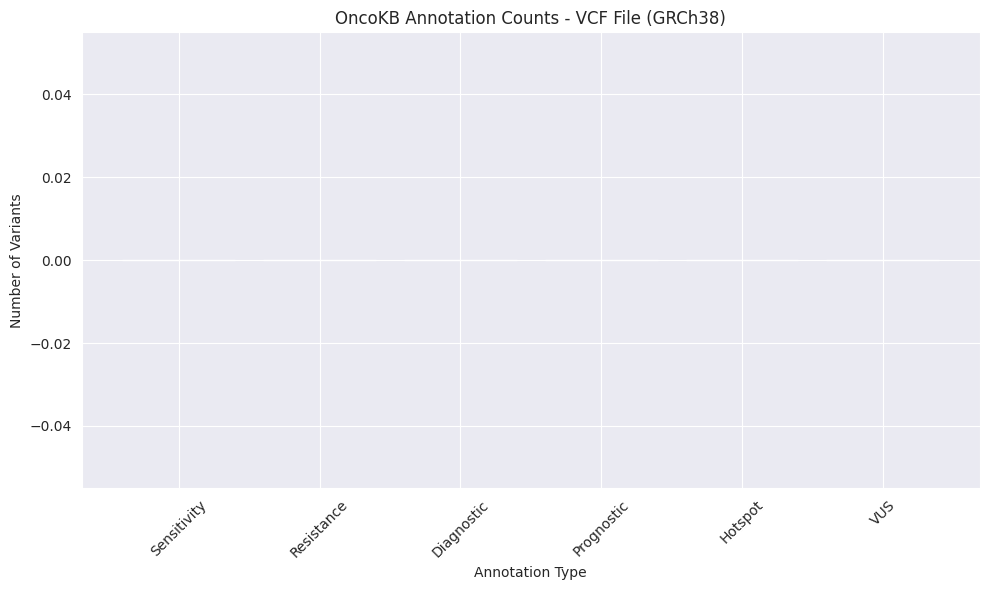


Found 0 actionable variants with sensitivity information


In [6]:
# Annotate the VCF data with OncoKB
if oncokb_token:
    logging.info("Annotating VCF data with OncoKB...")
    try:
        # Apply the monitoring patch
        requests.Session.post = logging_post
        
        # Perform the annotation
        vcf_annotated_data = vcf_py_mut.actionable_mutations_oncokb(
            token=oncokb_token,
            batch_size=1000,
            timeout=30,
            max_retries=3,
            retry_backoff=1.0
        )
        
        # Restore the original post method
        requests.Session.post = original_post
        
        # Show the first few rows of the annotated data
        print("\nSample of VCF data after annotation:")
        display(vcf_py_mut.data.head())
        
        # Show annotation statistics
        show_annotation_stats(vcf_py_mut, "VCF File (GRCh38)")
        
    except Exception as e:
        logging.error(f"Error during OncoKB annotation for VCF: {e}")
        # Restore the original post method
        requests.Session.post = original_post
else:
    logging.error("Cannot perform annotation without a valid OncoKB token")


## Part 2: Process MAF File (GRCh37)

Now, we'll load and annotate the MAF file with GRCh37 assembly.


In [7]:
print("\n" + "=" * 80)
print("PART 2: PROCESSING MAF FILE (GRCh37)")
print("=" * 80)

# Define the path to the MAF file
maf_path = "../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz"

# Load the MAF file with assembly 37
logging.info(f"Loading MAF file: {maf_path}")
maf_py_mut = read_maf(maf_path, assembly="37")

# Display basic information about the loaded data
logging.info(f"Loaded {len(maf_py_mut.data)} variants from MAF file")
logging.info(f"Assembly: {maf_py_mut.metadata.assembly}")

# Show the first few rows of the data
print("\nSample of MAF data before annotation:")
display(maf_py_mut.data.head())


2025-07-31 21:47:02,398 - root - INFO - Loading MAF file: ../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz
2025-07-31 21:47:02,399 - pyMut.input - INFO - Starting MAF reading: ../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz
2025-07-31 21:47:02,399 - pyMut.input - INFO - Loading from cache: ../../../src/pyMut/data/examples/MAF/.pymut_cache/tcga_laml.maf_4a8d2ba15c83f8cf.parquet
2025-07-31 21:47:02,418 - pyMut.input - INFO - Cache loaded successfully in 0.02 seconds
2025-07-31 21:47:02,418 - root - INFO - Loaded 2091 variants from MAF file
2025-07-31 21:47:02,419 - root - INFO - Assembly: 37



PART 2: PROCESSING MAF FILE (GRCh37)

Sample of MAF data before annotation:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,TCGA-AB-2988,TCGA-AB-2869,TCGA-AB-3009,...,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Protein_Change,i_TumorVAF_WU,i_transcript_name
0,chr9,100077177,.,T,C,.,.,T|T,T|T,T|T,...,+,SILENT,SNP,T,T,C,TCGA-AB-2886,p.T431T,9.76,NM_020893.1
1,chr9,100085148,.,G,A,.,.,G|G,G|G,G|G,...,+,MISSENSE_MUTATION,SNP,G,G,A,TCGA-AB-2917,p.R581H,18.4,NM_020893.1
2,chr9,100971322,.,A,C,.,.,A|A,A|A,A|A,...,+,MISSENSE_MUTATION,SNP,A,A,C,TCGA-AB-2841,p.L593R,45.83,NM_018421.3
3,chr9,104086335,.,C,T,.,.,C|C,C|C,C|C,...,+,MISSENSE_MUTATION,SNP,C,C,T,TCGA-AB-2877,p.T325I,37.12,NM_017753.2
4,chr9,104124840,.,G,A,.,.,G|A,G|G,G|G,...,+,MISSENSE_MUTATION,SNP,G,G,A,TCGA-AB-2988,p.T376M,48.35,NM_001701.1


### Annotate MAF data with OncoKB


2025-07-31 21:47:02,453 - root - INFO - Annotating MAF data with OncoKB...
2025-07-31 21:47:02,453 - pyMut.annotate.actionable_mutation - INFO - Using reference genome: GRCh37
2025-07-31 21:47:02,457 - pyMut.annotate.actionable_mutation - INFO - Splitting 2091 variants into 3 batches of max 1000 variants each
/home/luisruimore/anaconda3/envs/PyMutTFG/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
2025-07-31 21:47:02,458 - pyMut.annotate.actionable_mutation - INFO - Processing batch 1/3 with 697 variants
2025-07-31 21:47:02,490 - pyMut.annotate.actionable_mutation - INFO - Sending batch 1/3 to OncoKB API
2025-07-31 21:47:02,490 - root - INFO - API Request URL: https://www.oncokb.org/api/v1/annotate/mutations/byGenomicChange
2025-07-31 21:47:07,209 - root - INFO - API Response Status Code: 200
2025-07-31 21:47:07,21


Sample of MAF data after annotation:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,TCGA-AB-2988,TCGA-AB-2869,TCGA-AB-3009,...,oncokb_variantSummary,oncokb_tumorTypeSummary,oncokb_prognosticSummary,oncokb_diagnosticSummary,oncokb_diagnosticImplications,oncokb_prognosticImplications,oncokb_treatments,oncokb_dataVersion,oncokb_lastUpdate,oncokb_vus
0,chr9,100077177,.,T,C,.,.,T|T,T|T,T|T,...,,,,,[],[],[],v5.0,07/28/2025,False
1,chr9,100085148,.,G,A,.,.,G|G,G|G,G|G,...,,,,,[],[],[],v5.0,07/28/2025,False
2,chr9,100971322,.,A,C,.,.,A|A,A|A,A|A,...,,,,,[],[],[],v5.0,07/28/2025,False
3,chr9,104086335,.,C,T,.,.,C|C,C|C,C|C,...,,,,,[],[],[],v5.0,07/28/2025,False
4,chr9,104124840,.,G,A,.,.,G|A,G|G,G|G,...,,,,,[],[],[],v5.0,07/28/2025,False



MAF File (GRCh37)
Added 18 OncoKB annotation columns

Annotation statistics:
  Sensitivity: 76 variants
  Resistance: 15 variants
  Diagnostic: 177 variants
  Prognostic: 119 variants
  Hotspot: 91 variants
  VUS: 25 variants


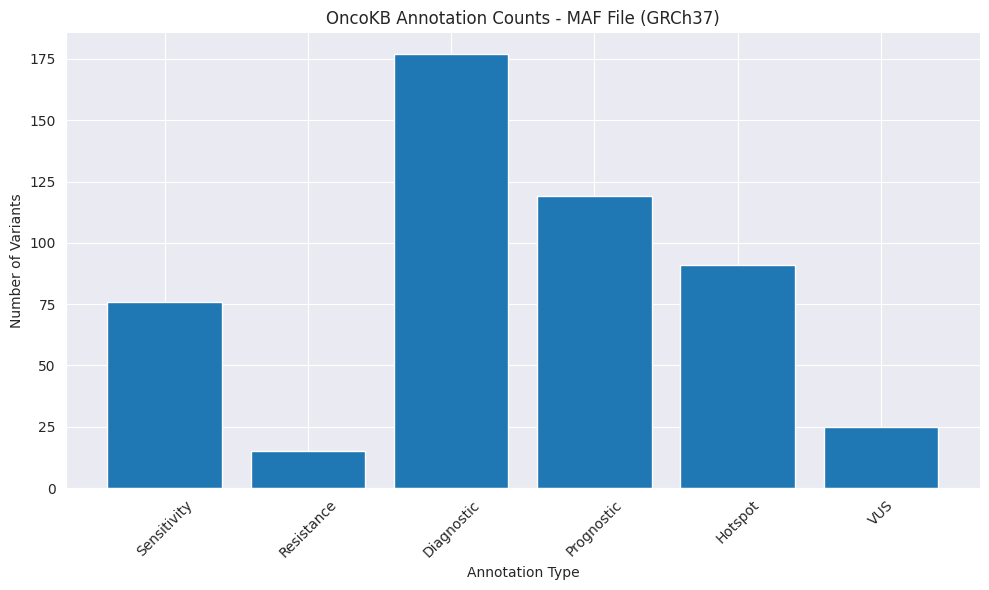


Found 76 actionable variants with sensitivity information


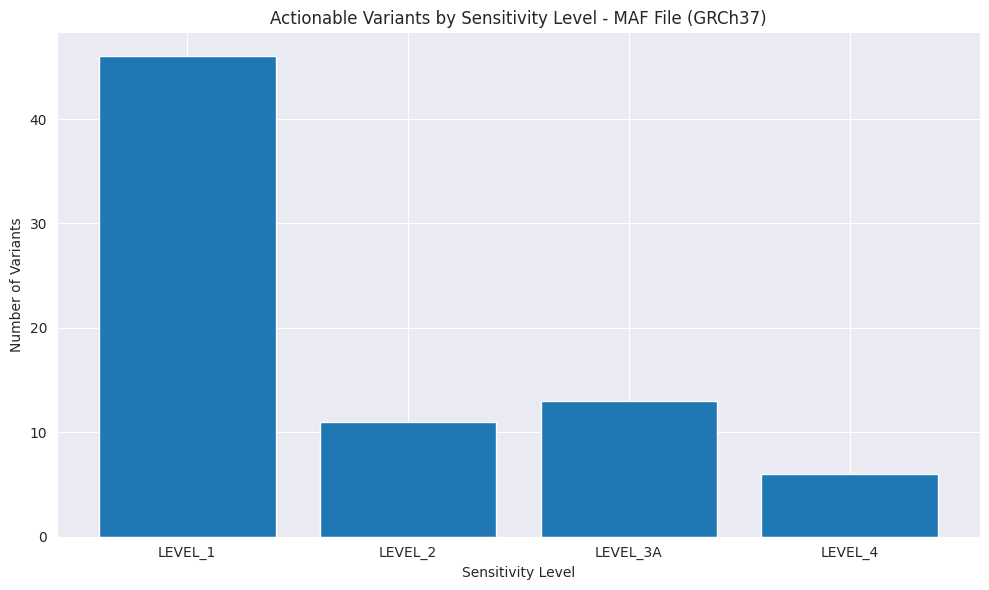


Sample of actionable variants:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,TCGA-AB-2988,TCGA-AB-2869,TCGA-AB-3009,...,oncokb_variantSummary,oncokb_tumorTypeSummary,oncokb_prognosticSummary,oncokb_diagnosticSummary,oncokb_diagnosticImplications,oncokb_prognosticImplications,oncokb_treatments,oncokb_dataVersion,oncokb_lastUpdate,oncokb_vus
142,X,44969323,.,G,A,.,.,G|G,G|G,G|G,...,There is no available functional data about th...,,,,[],[],"[{'alterations': ['Oncogenic Mutations'], 'dru...",v5.0,02/02/2023,True
267,chr2,198266834,.,T,C,.,.,T|T,T|T,T|T,...,The SF3B1 K700E mutation is likely oncogenic.,,,,"[{'levelOfEvidence': 'LEVEL_Dx2', 'alterations...","[{'levelOfEvidence': 'LEVEL_Px1', 'alterations...","[{'alterations': ['Oncogenic Mutations'], 'dru...",v5.0,08/08/2024,False
275,chr2,209113112,.,C,T,.,.,C|C,C|C,C|C,...,The IDH1 R132H mutation is known to be oncogenic.,,,,"[{'levelOfEvidence': 'LEVEL_Dx2', 'alterations...","[{'levelOfEvidence': 'LEVEL_Px2', 'alterations...","[{'alterations': ['R132C', 'R132H', 'R132G', '...",v5.0,08/10/2024,False
276,chr2,209113113,.,G,A,.,.,G|G,G|G,G|G,...,The IDH1 R132C mutation is known to be oncogenic.,,,,"[{'levelOfEvidence': 'LEVEL_Dx2', 'alterations...","[{'levelOfEvidence': 'LEVEL_Px2', 'alterations...","[{'alterations': ['R132C', 'R132H', 'R132G', '...",v5.0,08/10/2024,False
277,chr2,209113113,.,G,C,.,.,G|G,G|G,G|G,...,The IDH1 R132G mutation is known to be oncogenic.,,,,"[{'levelOfEvidence': 'LEVEL_Dx2', 'alterations...","[{'levelOfEvidence': 'LEVEL_Px2', 'alterations...","[{'alterations': ['R132C', 'R132H', 'R132G', '...",v5.0,08/10/2024,False


In [8]:
# Annotate the MAF data with OncoKB
if oncokb_token:
    logging.info("Annotating MAF data with OncoKB...")
    try:
        # Apply the monitoring patch
        requests.Session.post = logging_post
        
        # Perform the annotation
        maf_annotated_data = maf_py_mut.actionable_mutations_oncokb(
            token=oncokb_token,
            batch_size=1000,
            timeout=30,
            max_retries=3,
            retry_backoff=1.0
        )
        
        # Restore the original post method
        requests.Session.post = original_post
        
        # Show the first few rows of the annotated data
        print("\nSample of MAF data after annotation:")
        display(maf_py_mut.data.head())
        
        # Show annotation statistics
        show_annotation_stats(maf_py_mut, "MAF File (GRCh37)")
        
    except Exception as e:
        logging.error(f"Error during OncoKB annotation for MAF: {e}")
        # Restore the original post method
        requests.Session.post = original_post
else:
    logging.error("Cannot perform annotation without a valid OncoKB token")


## Part 3: Compare Annotation Results

Finally, we'll compare the annotation results from both files.



PART 3: COMPARING ANNOTATION RESULTS
Comparison of annotations between VCF (GRCh38) and MAF (GRCh37):


,VCF (GRCh38),MAF (GRCh37)
Sensitivity,0,76
Resistance,0,15
Diagnostic,0,177
Prognostic,0,119
Hotspot,0,91
VUS,0,25


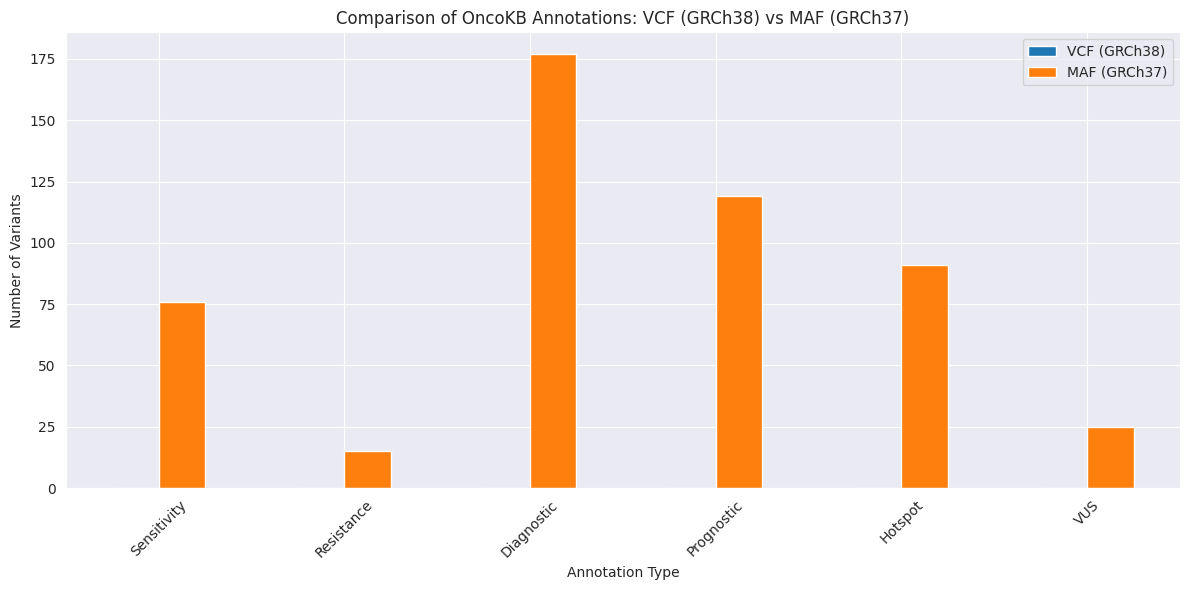


Annotation rates:
  VCF (GRCh38): 0/1000 variants annotated (0.00%)
  MAF (GRCh37): 207/2091 variants annotated (9.90%)

CONCLUSION:
This notebook has demonstrated how to use the export_oncokb_input method to annotate genomic variants
from files with different reference assemblies (GRCh38 for VCF and GRCh37 for MAF).
The OncoKB annotations provide valuable information about the clinical actionability of variants.


In [9]:
print("\n" + "=" * 80)
print("PART 3: COMPARING ANNOTATION RESULTS")
print("=" * 80)

# Check if both datasets were annotated
vcf_oncokb_columns = [col for col in vcf_py_mut.data.columns if col.startswith('oncokb_')]
maf_oncokb_columns = [col for col in maf_py_mut.data.columns if col.startswith('oncokb_')]

if vcf_oncokb_columns and maf_oncokb_columns:
    # Compare annotation statistics
    vcf_annotation_counts = {
        'Sensitivity': vcf_py_mut.data['oncokb_highestSensitiveLevel'].notna().sum() if 'oncokb_highestSensitiveLevel' in vcf_py_mut.data.columns else 0,
        'Resistance': vcf_py_mut.data['oncokb_highestResistanceLevel'].notna().sum() if 'oncokb_highestResistanceLevel' in vcf_py_mut.data.columns else 0,
        'Diagnostic': vcf_py_mut.data['oncokb_highestDiagnosticImplicationLevel'].notna().sum() if 'oncokb_highestDiagnosticImplicationLevel' in vcf_py_mut.data.columns else 0,
        'Prognostic': vcf_py_mut.data['oncokb_highestPrognosticImplicationLevel'].notna().sum() if 'oncokb_highestPrognosticImplicationLevel' in vcf_py_mut.data.columns else 0,
        'Hotspot': vcf_py_mut.data['oncokb_hotspot'].sum() if 'oncokb_hotspot' in vcf_py_mut.data.columns else 0,
        'VUS': vcf_py_mut.data['oncokb_vus'].sum() if 'oncokb_vus' in vcf_py_mut.data.columns else 0
    }
    
    maf_annotation_counts = {
        'Sensitivity': maf_py_mut.data['oncokb_highestSensitiveLevel'].notna().sum() if 'oncokb_highestSensitiveLevel' in maf_py_mut.data.columns else 0,
        'Resistance': maf_py_mut.data['oncokb_highestResistanceLevel'].notna().sum() if 'oncokb_highestResistanceLevel' in maf_py_mut.data.columns else 0,
        'Diagnostic': maf_py_mut.data['oncokb_highestDiagnosticImplicationLevel'].notna().sum() if 'oncokb_highestDiagnosticImplicationLevel' in maf_py_mut.data.columns else 0,
        'Prognostic': maf_py_mut.data['oncokb_highestPrognosticImplicationLevel'].notna().sum() if 'oncokb_highestPrognosticImplicationLevel' in maf_py_mut.data.columns else 0,
        'Hotspot': maf_py_mut.data['oncokb_hotspot'].sum() if 'oncokb_hotspot' in maf_py_mut.data.columns else 0,
        'VUS': maf_py_mut.data['oncokb_vus'].sum() if 'oncokb_vus' in maf_py_mut.data.columns else 0
    }
    
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'VCF (GRCh38)': vcf_annotation_counts,
        'MAF (GRCh37)': maf_annotation_counts
    })
    
    print("Comparison of annotations between VCF (GRCh38) and MAF (GRCh37):")
    display(comparison_df)
    
    # Visualize comparison
    comparison_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Comparison of OncoKB Annotations: VCF (GRCh38) vs MAF (GRCh37)')
    plt.xlabel('Annotation Type')
    plt.ylabel('Number of Variants')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate annotation rates
    vcf_total = len(vcf_py_mut.data)
    maf_total = len(maf_py_mut.data)
    
    vcf_annotated = vcf_py_mut.data[vcf_py_mut.data['oncokb_highestSensitiveLevel'].notna() | 
                                    vcf_py_mut.data['oncokb_highestResistanceLevel'].notna() | 
                                    vcf_py_mut.data['oncokb_highestDiagnosticImplicationLevel'].notna() | 
                                    vcf_py_mut.data['oncokb_highestPrognosticImplicationLevel'].notna()].shape[0] if all(col in vcf_py_mut.data.columns for col in ['oncokb_highestSensitiveLevel', 'oncokb_highestResistanceLevel', 'oncokb_highestDiagnosticImplicationLevel', 'oncokb_highestPrognosticImplicationLevel']) else 0
    
    maf_annotated = maf_py_mut.data[maf_py_mut.data['oncokb_highestSensitiveLevel'].notna() | 
                                    maf_py_mut.data['oncokb_highestResistanceLevel'].notna() | 
                                    maf_py_mut.data['oncokb_highestDiagnosticImplicationLevel'].notna() | 
                                    maf_py_mut.data['oncokb_highestPrognosticImplicationLevel'].notna()].shape[0] if all(col in maf_py_mut.data.columns for col in ['oncokb_highestSensitiveLevel', 'oncokb_highestResistanceLevel', 'oncokb_highestDiagnosticImplicationLevel', 'oncokb_highestPrognosticImplicationLevel']) else 0
    
    print("\nAnnotation rates:")
    print(f"  VCF (GRCh38): {vcf_annotated}/{vcf_total} variants annotated ({vcf_annotated/vcf_total*100:.2f}%)")
    print(f"  MAF (GRCh37): {maf_annotated}/{maf_total} variants annotated ({maf_annotated/maf_total*100:.2f}%)")
    
    # Conclusion
    print("\nCONCLUSION:")
    print("This notebook has demonstrated how to use the export_oncokb_input method to annotate genomic variants")
    print("from files with different reference assemblies (GRCh38 for VCF and GRCh37 for MAF).")
    print("The OncoKB annotations provide valuable information about the clinical actionability of variants.")
else:
    print("Cannot compare results because one or both datasets were not annotated successfully.")